In [1]:
import pcae
import numpy as np
import matplotlib.pyplot as plt
import utils

import torch

In [2]:
#load data
dataset = pcae.PointCloudDataSet('../data/3DShapeNet_PointCloud2048.npz', feature_fname='chair', train=False)


In [3]:
#load model
model = pcae.PointCloudAutoEncoder(n_points=2048, latent_size=8)
model.load_model('./models/pcae_epoch_499.pth', cuda=False)

In [4]:
x_test = dataset[8]
x_test = torch.Tensor(x_test[np.newaxis, :])

x_test_hat, z_test, _ = model(x_test)

<IPython.core.display.Javascript object>


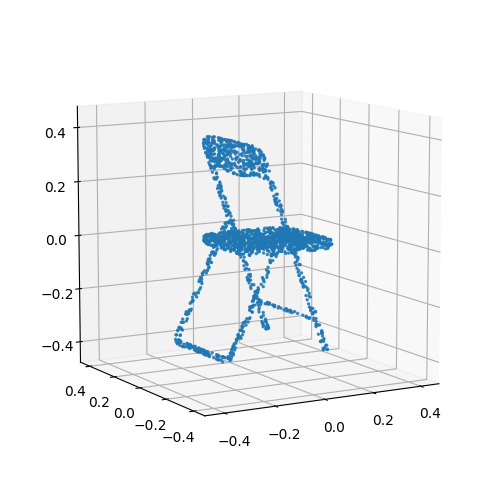

<IPython.core.display.Javascript object>


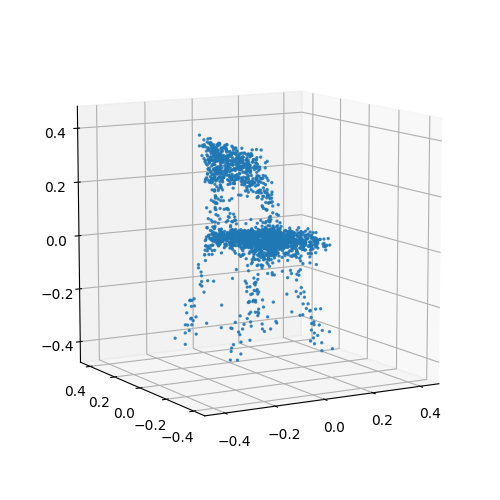

Figure(500x500) Figure(500x500)


In [28]:
%matplotlib notebook
#plot
x_test_plot = x_test.detach().numpy()[0]
x_test_hat_plot = x_test_hat.detach().numpy()[0]
fig1 = utils.plot_3d_point_cloud(x_test_plot[0, :], x_test_plot[1, :], x_test_plot[2, :])
fig2 = utils.plot_3d_point_cloud(x_test_hat_plot[0, :], x_test_hat_plot[1, :], x_test_hat_plot[2, :])
print(fig1, fig2)

In [10]:
err = []
for i in range(len(dataset)):
    x_test = torch.Tensor((dataset[i])[np.newaxis, :])

    x_test_hat, z_test, _ = model(x_test)
    recons_loss = model.reconstruction_loss(x_test, x_test_hat)
    err.append(recons_loss.item())
print(np.mean(err))

0.02929078060776479


In [8]:
#transform the training dataset
train_dataset = pcae.PointCloudDataSet('../data/3DShapeNet_PointCloud2048.npz', feature_fname='chair', train=True)
train_dataloader = torch.utils.data.DataLoader(
            dataset=train_dataset,
            batch_size=8,
            shuffle=True
        )

latent_encodings = np.vstack([model.encode(batch)[0].detach().numpy() for batch in train_dataloader])
    

In [4]:
#print(latent_encodings.shape)
#np.savez('../data/3DShapeNet_PointCloud2048_Chair_LatentEncodings8', data=latent_encodings)
latent_encodings = np.load('../data/3DShapeNet_PointCloud2048_Chair_LatentEncodings8.npz')
print(latent_encodings['data'].shape)
print(np.any(np.isnan(latent_encodings['data'])))

(5422, 8)
False


In [6]:
#fit GMM
pcgmm = pcae.PointCloudGenerativeGMM(auto_encoder=model, n_components=3, covar_type='full')


In [13]:
pcgmm.fit_gmm(torch.from_numpy(latent_encodings['data'].astype(np.float64)), raw_feature=False, kmeans_init=True)

Fitting GMM in the latent space...
score improvement: tensor(inf, dtype=torch.float64)
score improvement: tensor(271.5515, dtype=torch.float64)
score improvement: tensor(225.9390, dtype=torch.float64)
score improvement: tensor(218.8691, dtype=torch.float64)
score improvement: tensor(228.2682, dtype=torch.float64)
score improvement: tensor(233.2651, dtype=torch.float64)
score improvement: tensor(191.5818, dtype=torch.float64)
score improvement: tensor(100.0360, dtype=torch.float64)
score improvement: tensor(31.9866, dtype=torch.float64)
score improvement: tensor(11.6483, dtype=torch.float64)
score improvement: tensor(5.8475, dtype=torch.float64)
score improvement: tensor(3.4488, dtype=torch.float64)
score improvement: tensor(2.2497, dtype=torch.float64)
score improvement: tensor(1.5907, dtype=torch.float64)
score improvement: tensor(1.2079, dtype=torch.float64)
score improvement: tensor(0.9785, dtype=torch.float64)
score improvement: tensor(0.8406, dtype=torch.float64)
score improvement

In [7]:
#pcgmm.save_model('pcgmm_latent8_20190312')
pcgmm.load_model('pcgmm_latent8_20190312.pth')
#pcgmm.double()
#pcgmm.auto_encoder.double()
#pcgmm.auto_encoder.pointnet_feature.double()

In [31]:
sampled_pc = pcgmm.sample(n_samples=9).detach().numpy()
print(sampled_pc.shape)

(9, 3, 2048)


<IPython.core.display.Javascript object>


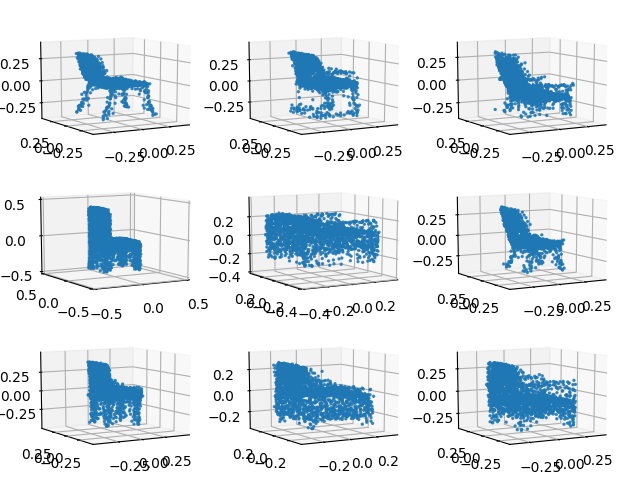

In [32]:
%matplotlib notebook
fig = plt.figure()
ax = [None] * 9
for i in range(3):
    for j in range(3):
        ax[i*3+j] = fig.add_subplot(3, 3, i*3+j+1, projection='3d')
        sampled_pc_plot = sampled_pc[i*3+j]
        utils.plot_3d_point_cloud(sampled_pc_plot[0, :], sampled_pc_plot[1, :], sampled_pc_plot[2, :], show_axis=True, axis=ax[i*3+j])


In [33]:
#try completion of shapes
test_input_full = dataset[64]
test_input_half = test_input_full[:, :1024]      #cut plane with z normal
#test_input_half = np.concatenate((test_input_full[:, :512], test_input_full[:, 1536:]), axis=1) #cut middle part

#duplicate existing ones for same input dimension
test_input_2048 = np.concatenate((test_input_half, test_input_half+np.random.randn(*test_input_half.shape)*.01), axis=1)


In [34]:
#push this and see what is going on
test_output = pcgmm.fit_shapes(torch.from_numpy(test_input_2048[np.newaxis, :]).float(), verbose=True, lr=.1, n_iters=5)

Iteration 1 - Reconstruction Loss/GMM Likelihood: 0.03722217306494713/4.2958834001183277e-07
Iteration 2 - Reconstruction Loss/GMM Likelihood: 0.03218315541744232/1.0835586863322533e-06
Iteration 3 - Reconstruction Loss/GMM Likelihood: 0.028013505041599274/2.714826450755936e-06
Iteration 4 - Reconstruction Loss/GMM Likelihood: 0.024943100288510323/5.547482032852713e-06
Iteration 5 - Reconstruction Loss/GMM Likelihood: 0.023535702377557755/8.97520840226207e-06


<IPython.core.display.Javascript object>


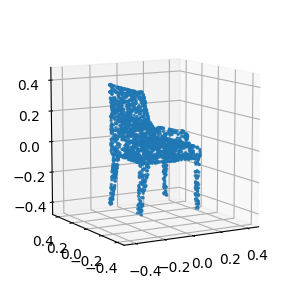

<IPython.core.display.Javascript object>


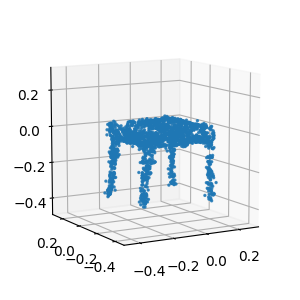

<IPython.core.display.Javascript object>


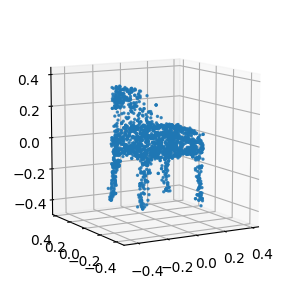

In [35]:
test_output_complete = test_output.detach().numpy()[0]
test_output_complete = np.concatenate((test_input_2048, test_output_complete), axis=1)
#subsample back to 2048 points
test_output_complete = test_output_complete[:, np.random.choice(test_output_complete.shape[1], 2048)]
%matplotlib notebook
#original, augmented half, complete
fig1 = utils.plot_3d_point_cloud(test_input_full[0, :], test_input_full[1, :], test_input_full[2, :], figsize=(3, 3))
fig2 = utils.plot_3d_point_cloud(test_input_2048[0, :], test_input_2048[1, :], test_input_2048[2, :], figsize=(3, 3))
fig3 = utils.plot_3d_point_cloud(test_output_complete[0, :], test_output_complete[1, :], test_output_complete[2, :], figsize=(3, 3))